In [1]:
# Packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Pipeline
from tree import TreeModel

# ===== import data; tr,ts ======
X_tr = pd.read_csv('split-data/processed/X_tr.csv')
X_ts = pd.read_csv('split-data/processed/X_ts.csv')
y_tr = pd.read_csv('split-data/processed/y_tr.csv')
y_ts = pd.read_csv('split-data/processed/y_ts.csv')

In [2]:
# ===== Random Forest ======
start = time.time()

rf_params = {
    'X_tr': X_tr.to_numpy(),
    'X_ts': X_ts.to_numpy(),
    'y_tr': y_tr.values.ravel(),
    'y_ts': y_ts.values.ravel(),
    'model': RandomForestClassifier(),
    'name': 'Random Forest'
}


rf_pipeline = TreeModel(**rf_params)

rf_fit_params = {
    'param_grid': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 20, 50],
        'min_samples_leaf': [1, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': [5, 10, 50, 100]
    },
    'balance_classes': False,
    'k_folds': 2,
    'scoring': 'accuracy'
}
rf_pipeline.fit_predict(**rf_fit_params)

end = time.time()
elapsed = end - start
print(f"Elapsed time: {elapsed:.2f} seconds")

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Elapsed time: 275.08 seconds


Best Hyperparameters: {'max_depth': 20, 'max_features': 50, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
RandomForestClassifier()
Grid - Hyperparameters: ['n_estimators', 'max_depth', 'min_samples_leaf', 'min_samples_split', 'max_features']
Train Accuracy: 90.465%
CV Validation Accuracy: 85.581%
Test Accuracy: 85.983%


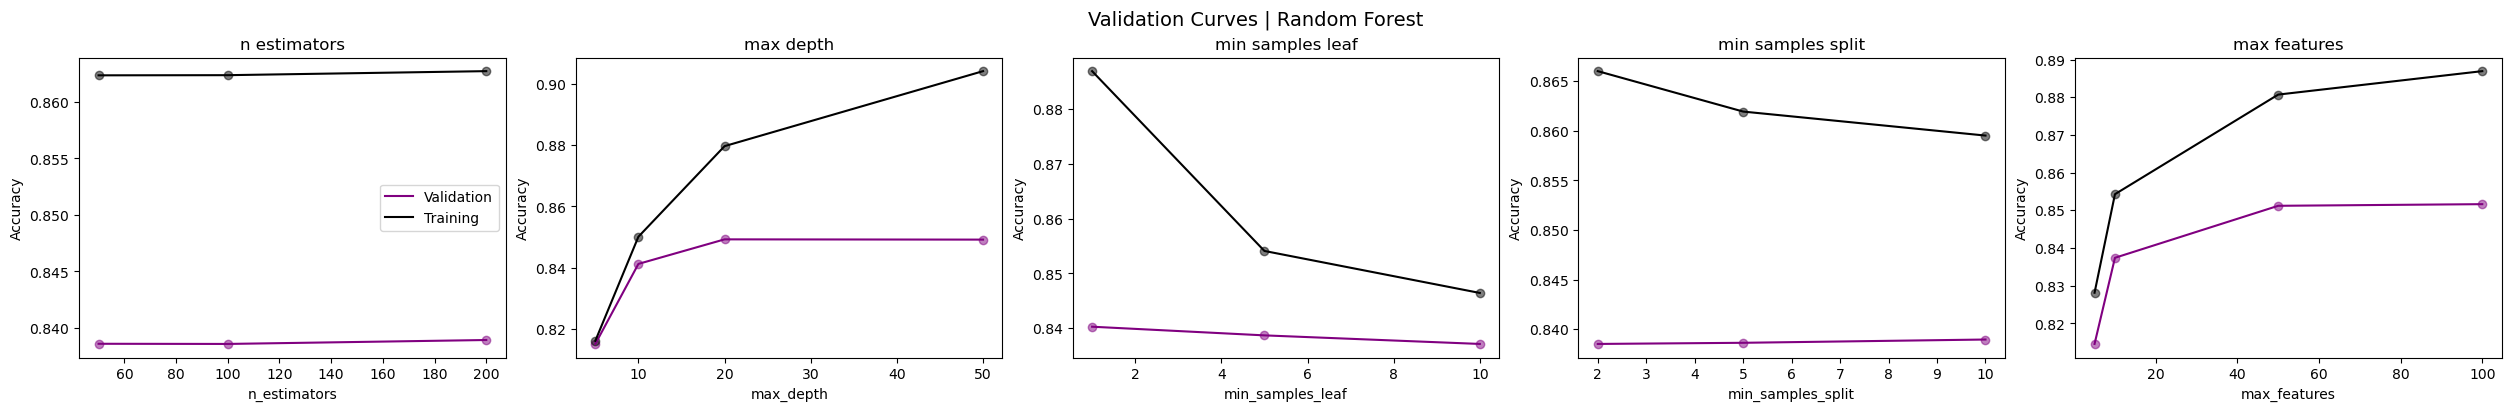

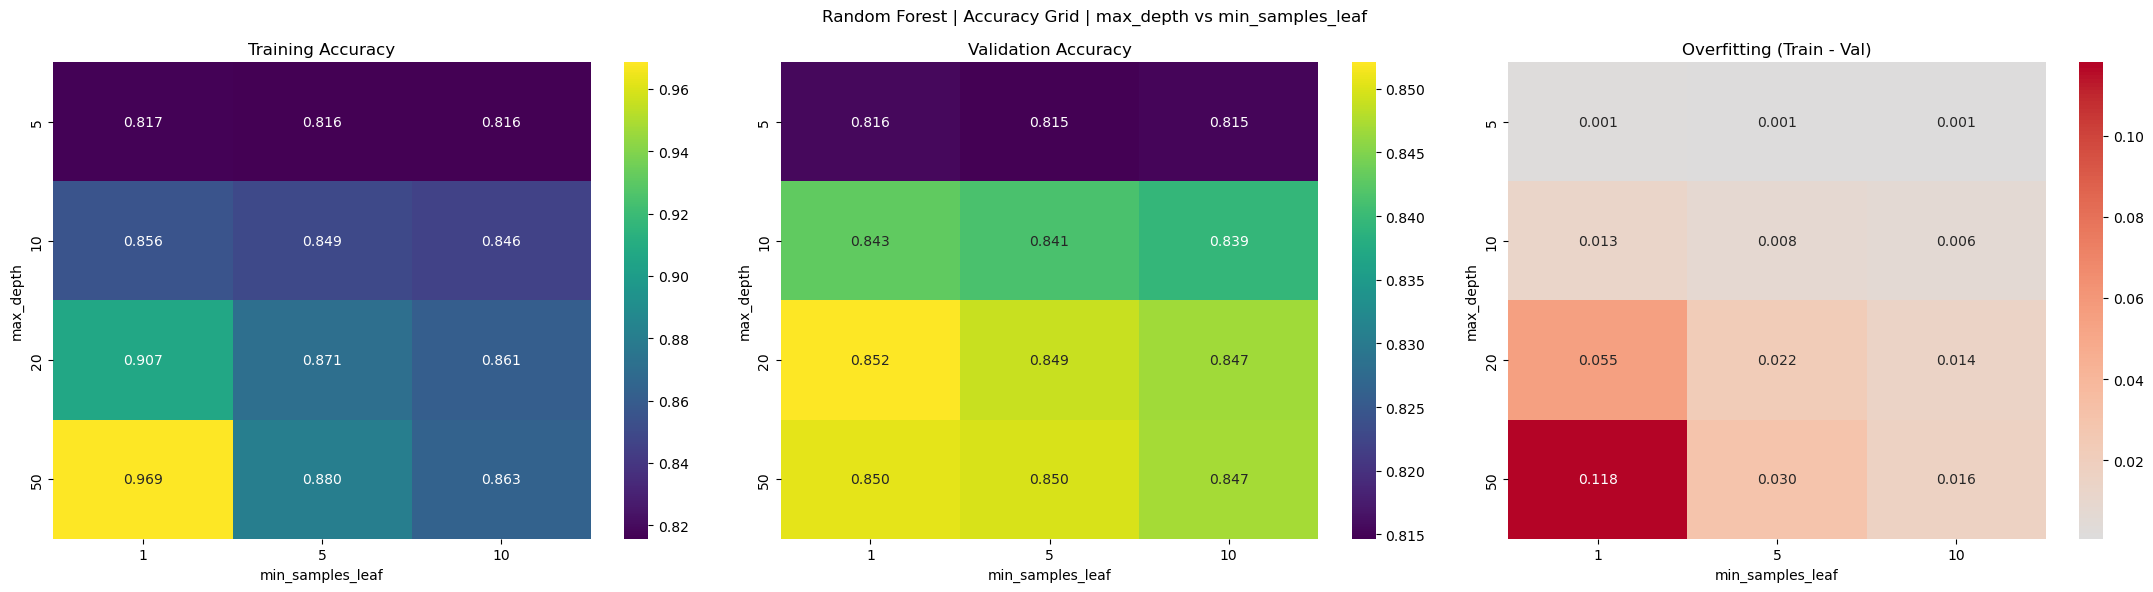

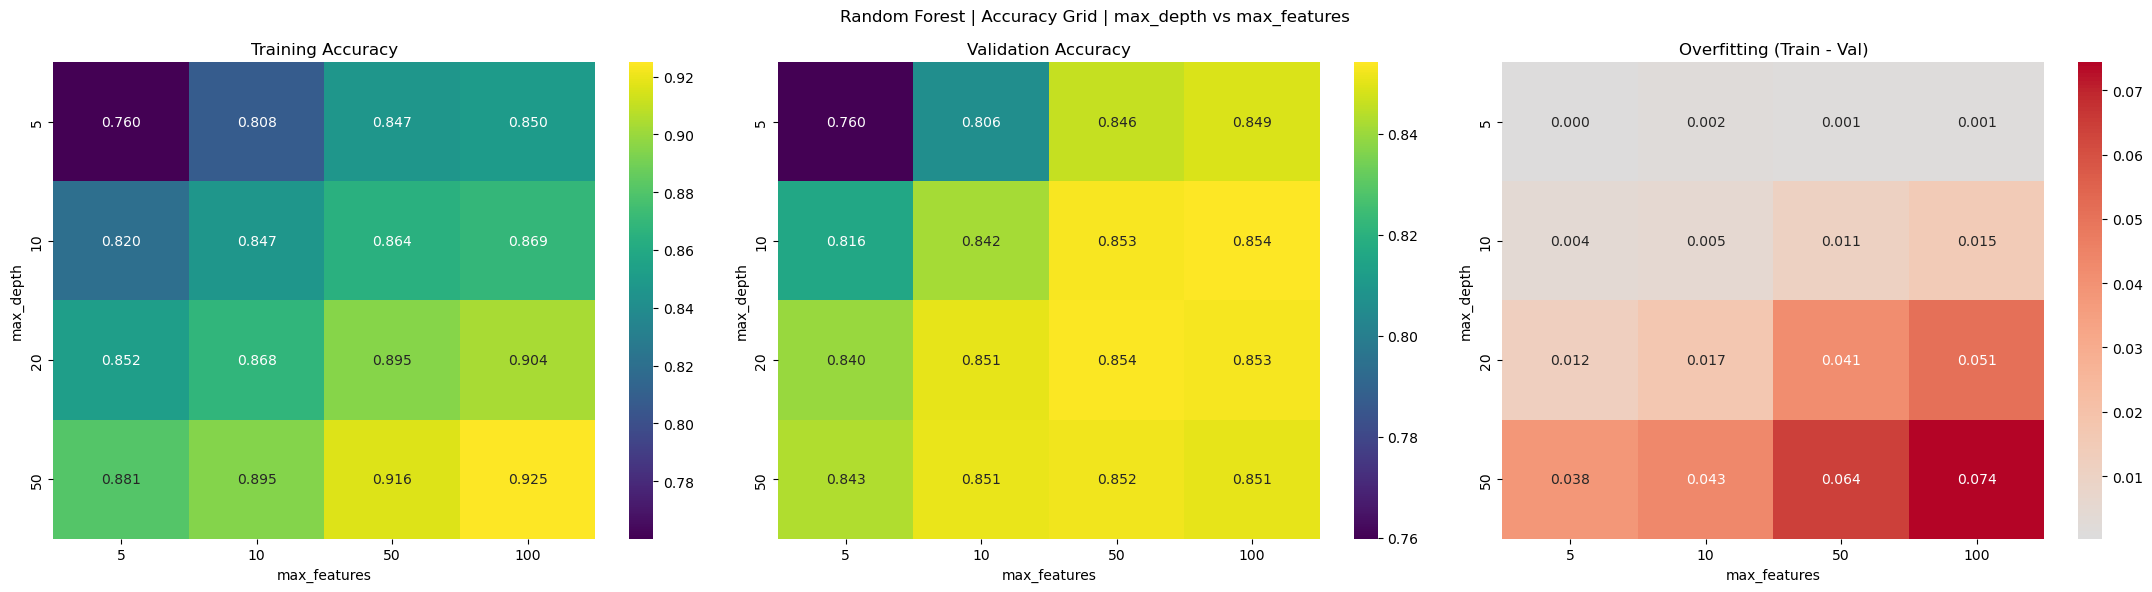

In [3]:
print("Best Hyperparameters:", rf_pipeline.grid.best_params_)
rf_pipeline.tr_ts_scoring

os.makedirs('media/03_random_forest', exist_ok=True)
plot_vhgr_params = {
    'param_list':rf_pipeline.hyper_grid,
    'figsize':(5, 4),
    'save_path':'media/03_random_forest/balanced_validation_curves.png'
}
rf_pipeline.plot_validation_hyperparam_grid_row(**plot_vhgr_params)

rf_pipeline.viz_heatmap_cv(top_two_params_for_overfitting=['max_depth','min_samples_leaf'], dir_save_path='media/03_random_forest')

rf_pipeline.viz_heatmap_cv(top_two_params_for_overfitting=['max_depth','max_features'], dir_save_path='media/03_random_forest')

Overfitting occurs at red heatmap parts which is when min_samples_leaf is small (makes nodes pure, fits to noise), max_depth is large, and max_featires is large (removes independence among trees and breaks LLN - assumption of RF).

Plot a single decision tree among the RF for viz purposes.

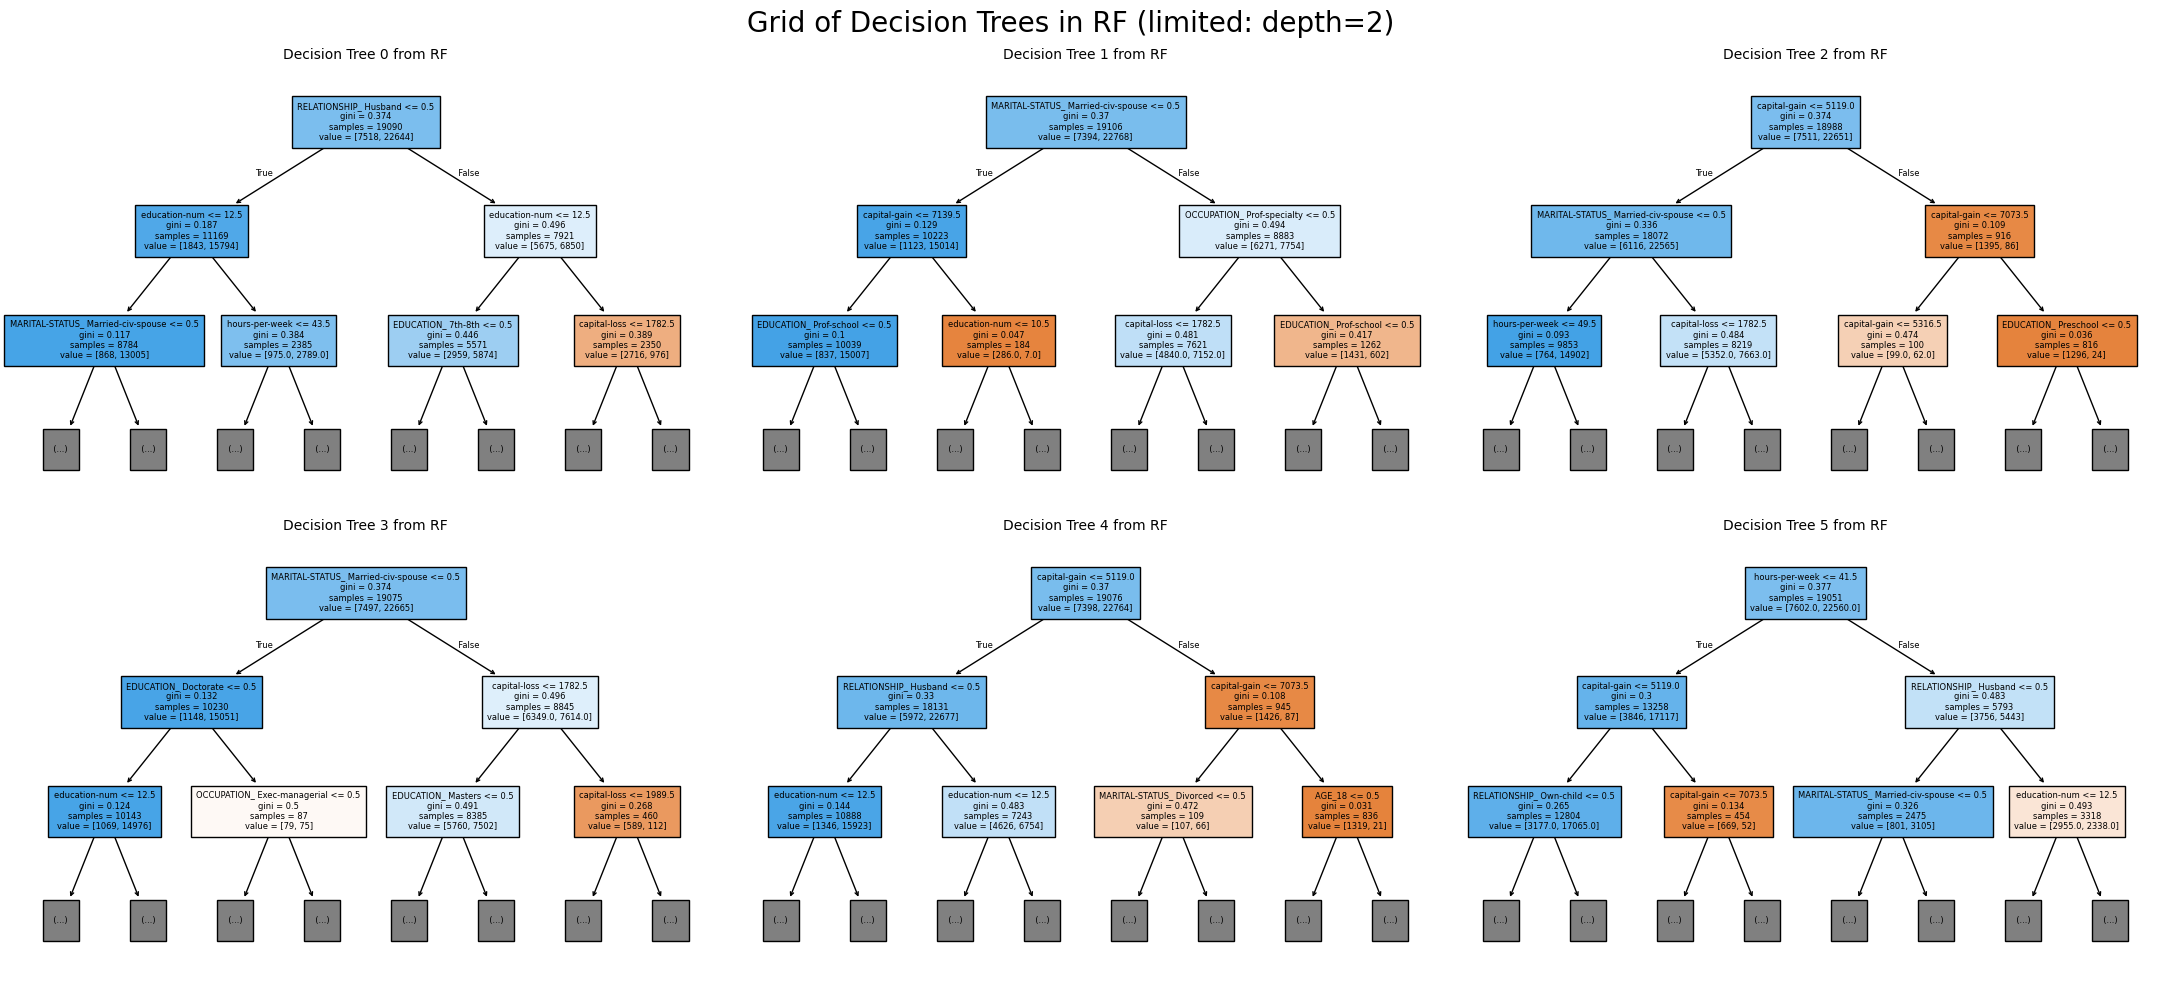

In [36]:
rf_model = rf_pipeline.grid.best_estimator_
depth = 2

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

for i in range(6):  # Plot 6 trees
    plot_tree(
        rf_model.estimators_[i],
        filled=True,
        max_depth=depth,
        feature_names=X_tr.columns,
        fontsize=6,
        ax=axes[i]  # Specify the individual subplot
    )
    axes[i].set_title(f'Decision Tree {i} from RF', fontsize=10)

plt.suptitle(f'Grid of Decision Trees in RF (limited: depth={depth})', fontsize=20)
plt.tight_layout()
plt.savefig('media/03_random_forest/multiple_tree_viz.png', bbox_inches='tight')
plt.show()


Feature importance viz.

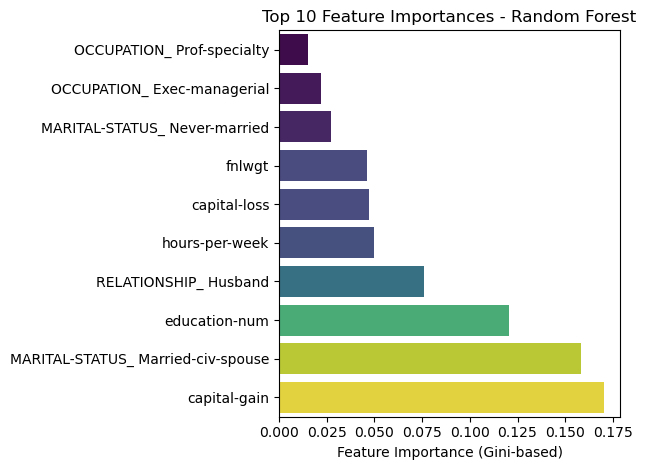

In [37]:
k = 10
best_rf = rf_pipeline.grid.best_estimator_  # best model from grid search

rf_importances = pd.Series(best_rf.feature_importances_, index=X_tr.columns)
top_features = rf_importances.sort_values(ascending=False).head(k)

sns.barplot(
    x=top_features.sort_values().values,
    y=top_features.sort_values().index,
    hue=top_features.sort_values().values,
    dodge=False,
    palette='viridis',
    legend=False
)

plt.title(f"Top {k} Feature Importances - Random Forest")
plt.xlabel("Feature Importance (Gini-based)")
plt.ylabel('')
plt.tight_layout()
plt.savefig('media/03_random_forest/significant_features_viz.png')
plt.show()
